# Forecasting electricity demand on french market

### Situation

“Enercoop”, a cooperative company specializing in renewable energies, has expanded thanks to the liberalization of the electricity market in France. However, most of these renewable energies are intermittent, making it difficult to forecast electricity production capacity. What's more, user demand for electricity varies over time, and depends on parameters such as the weather (temperature, luminosity, etc.). Here, the challenge is to match supply and demand.

### What is renewable energy?
Energy is said to be renewable when it comes from sources that nature constantly renews, as opposed to non-renewable energy whose stocks run out.

Renewable energies come from 2 major natural sources: the Sun (which drives the water cycle, tides, wind and plant growth) and the Earth (which releases heat).

Nicknamed “clean energies” or “green energies”, their exploitation generates very little waste and polluting emissions, but their energy power is much lower than that of non-renewable energies.

## The challenges and objectives of electricity demand forecasting :

Electricity cannot be stored, and overall production on the French power grid must be strictly equal to consumption at all times. Any change in electricity demand or production at any point on the network has instant repercussions for the entire power system. The system must therefore constantly adapt to satisfy the supply-demand balance.


In [1]:
# !pip install pmdarima

In [2]:
# Import principals library

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro
from IPython.display import clear_output
from time import time

import itertools
import warnings
warnings.filterwarnings('ignore')

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Version of python library


print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))
print("Statsmodels : " + str(sm.__version__))

Jupyter Notebook : 2.2.2
Pandas : 2.2.2
Numpy : 1.26.4
Matplotlib : 3.9.0
Seaborn : 0.13.2
Statsmodels : 0.14.2


## Processing the dataset exported from the RTE website

In [4]:
# Download dataset on 'consommation.csv'
data_conso = pd.read_csv('p9_data/consommation.csv', sep=';', parse_dates=[0]) #pare_dates convert the object in the first column in datetime object
data_conso.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
0,0000-00,Données consolidées,Grand-Est,11346,8643.0,1120,22.0,2,1095,565,...,4545,6711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données consolidées,Nouvelle-Aquitaine,5289,4179.0,164,NaN,0,164,419,...,4578,711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données consolidées,Auvergne-Rhône-Alpes,11622,8382.0,334,6.0,11,316,2630,...,6834,4483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données consolidées,Bourgogne-Franche-Comté,467,NaN,124,NaN,0,123,89,...,2188,-1724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données consolidées,Bretagne,535,NaN,182,NaN,4,178,59,...,2443,-1915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Mensual data for electricity total consumption only in France

conso = data_conso.copy()
conso = conso[["Mois", "Territoire", "Consommation totale"]]
conso = conso[conso['Territoire'] == 'France']
conso.drop('Territoire', axis=1, inplace=True)
conso.rename(columns={'Mois': 'mois', 'Consommation totale': 'consommation'}, inplace=True)


In [6]:
#Display mensual total consumption of electricity
display(conso.head())
display(conso.shape)

,mois,consommation
6,0000-00,49559
13,2012-01,51086
14,2012-02,54476
15,2012-03,43156
16,2012-04,40176


(99, 2)

In [7]:
#Look for outliers like the one in the first line
conso.drop(6, axis=0, inplace=True)

In [8]:
# Change type of the first column in datetime
conso['mois'] = pd.to_datetime(conso['mois'])
conso.set_index('mois', inplace=True)
conso

,consommation
mois,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257
...,...
2019-10-01,36482
2019-11-01,44180
2019-12-01,47096


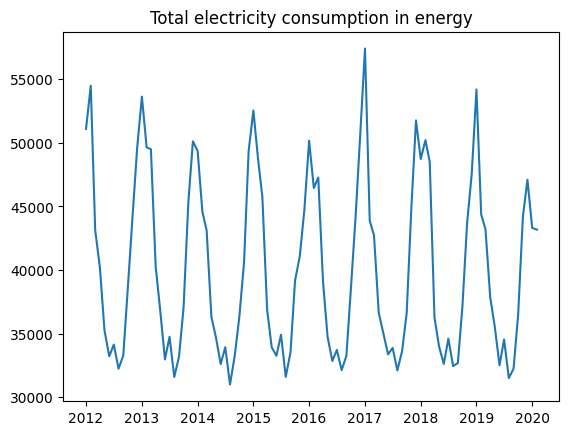

In [9]:
# Visualize total consumption of electricity
plt.plot(conso.consommation)
plt.title("Total electricity consumption in energy")
plt.savefig("p9_graphic/conso_elect.png")
plt.show()

In the above time series, we can identtify fairly regular cycles over time and of similar amplitude. Monthly consumtion data will be corrected for the temperature effect using linear regression. It is necessary to extract data due to electric heating over the same period in order to see the influence of other factor like behavior of customers, holiday and economic activity in the consumptin of electricity.

In [10]:
# Resampling data per year
conso.resample('Y').sum()

,consommation
mois,
2012-12-31,489517
2013-12-31,494842
2014-12-31,465150
2015-12-31,476050
2016-12-31,483219
2017-12-31,482008
2018-12-31,478431
2019-12-31,473739
2020-12-31,86473


## Processing the dataset exported from the Cegibat website

In [11]:
# Load data
data_dju = pd.read_csv('p9_data/dju.csv', encoding= "utf-8", sep = ";", skiprows=11, header=None)
data_dju.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
1,2019.0,"404,9","268,3","233,1","168,5","117,9",14,0,0,0,0,0,0,"1206,6"
2,2018.0,"303,4","432,6","314,3","119,7","55,9","8,1",0,"3,3","34,3","122,4","282,5","325,9","2002,2"
3,2017.0,"467,9","278,4","206,1","182,6",75,"9,4",1,"6,8","62,6","99,4","282,6",369,"2040,6"
4,2016.0,"364,4","321,6","321,1","212,1","88,1","27,5","5,7","3,2","11,7",176,"285,6","390,8","2207,3"


We will remove 2019 data because, we have null values on winter months

In [12]:
# Remove the 2 first lines and the last series
data_dju.drop([0, 1], axis=0, inplace=True)
data_dju.drop([13], axis=1, inplace=True)

In [13]:
# The first series is the index
data_dju[0] = data_dju[0].astype(int)
data_dju.set_index([0], inplace=True)

In [14]:
data_dju.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
2018,"303,4","432,6","314,3","119,7","55,9","8,1",0,"3,3","34,3","122,4","282,5","325,9"
2017,"467,9","278,4","206,1","182,6",75,"9,4",1,"6,8","62,6","99,4","282,6",369
2016,"364,4","321,6","321,1","212,1","88,1","27,5","5,7","3,2","11,7",176,"285,6","390,8"
2015,392,"365,7","275,5","141,1","91,5","15,8","6,9","6,1","71,9","176,9",195,"248,1"
2014,"324,4","281,9","223,9","135,5","100,2","19,1","8,3","19,3",16,"92,3","222,6","368,2"


Now we will transform it in temporal matrix

In [15]:
#Transformation of data

dju = {'mois': [], 'dju_chauffage': []}

for year in data_dju.index.values:
    for month in data_dju.columns:
        dju['mois'].append(f"{year}-{month}")
        dju['dju_chauffage'].append(data_dju.loc[year, month])

dju = pd.DataFrame(dju)
dju['mois'] = pd.to_datetime(dju['mois'])

In [16]:
# set index with mois columns
dju.set_index('mois', inplace=True)

In [17]:
# Monthly data 
display(dju.head())
display(dju.shape)


,dju_chauffage
mois,
2018-01-01,"303,4"
2018-02-01,"432,6"
2018-03-01,"314,3"
2018-04-01,"119,7"
2018-05-01,"55,9"


(120, 1)

In [18]:
dju['dju_chauffage'] = dju['dju_chauffage'].str.replace(',', '.').astype(float)

In [19]:
dju

,dju_chauffage
mois,
2018-01-01,303.4
2018-02-01,432.6
2018-03-01,314.3
2018-04-01,119.7
2018-05-01,55.9
...,...
2009-08-01,0.9
2009-09-01,26.9
2009-10-01,149.6


In [20]:
dju_res = dju.resample('M').sum()

In [21]:
dju_res

,dju_chauffage
mois,
2009-01-31,486.8
2009-02-28,365.7
2009-03-31,293.2
2009-04-30,135.1
2009-05-31,82.2
...,...
2018-08-31,3.3
2018-09-30,34.3
2018-10-31,122.4


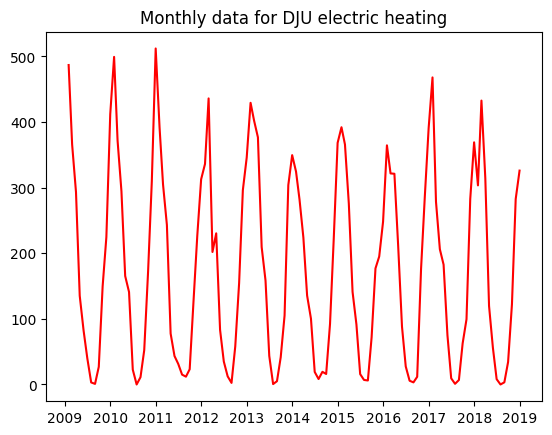

In [22]:
#Display dataset
plt.plot(dju_res.dju_chauffage, color='r')
plt.title("Monthly data for DJU electric heating")
plt.savefig("p9_graphic/dju_elec_heating.png")
plt.show()


This time series naturally takes into account seasonality linked to climatic conditions. Our monthly cycles therefore evolve according to temperature, and other exogenous factors not taken into account in the study, such as humidity, the impact of pollution, etc. Finally, UDDs summed over a period can be used to calculate a building's heating and cooling requirements.

In [23]:
#Merge the two data
df = pd.merge(conso, dju, how='inner', on='mois')
df

,consommation,dju_chauffage
mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3
...,...,...
2018-08-01,32451,3.3
2018-09-01,32683,34.3
2018-10-01,37102,122.4


In [24]:

df.isna().any()

consommation     False
dju_chauffage    False
dtype: bool

Les années 2019 et 2020 ne peuvent pas être validées pour l'analyse, des valeurs manquantes sont présentes sur ces deux années. Avec une jointure 'inner' l'exclusion est automatiquement réalisée.

In [25]:
#Statistiques descriptives de l'échantillon
df.describe().T

,count,mean,std,min,25%,50%,75%,max
consommation,84.0,40109.726190,7135.547804,31004.0,33696.75,37082.5,45914.250,57406.0
dju_chauffage,84.0,174.596429,143.731842,0.0,32.60,156.5,303.525,467.9



If we analyze the two graphs, we can see that higher heating consumption leads to higher electricity consumption. These two variables are therefore linked. With the working sample now complete, the next step is to correct the electricity consumption data for the temperature effect caused by heating. Linear regression will be used.

# Correction of monthly consumption data for temperature effect

The temperature effect (due to electric heating) will therefore be corrected by linear regression. Scikit-learn can be used, or Statsmodels, for comparison purposes.

In [26]:
# Preparing data for linear regression
y = df["consommation"]
x = df.drop(columns=['consommation'])

In [27]:
# Linear regression by scikit-learn
from sklearn import linear_model
reg= linear_model.LinearRegression(fit_intercept=True)
reg.fit(x, y)

LinearRegression()

In [28]:
# linear regression coef
reg.coef_[0]

48.49191639056928

# Linear regression can also be treat by statsmodels

In [29]:
# Preparing data
y = df["consommation"]
x = sm.add_constant(df['dju_chauffage'])

In [30]:
#New regression by Statsmodels
#Model and training
reg = sm.OLS(y, x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1704.
Date:                Mon, 27 May 2024   Prob (F-statistic):           1.23e-56
Time:                        16:41:17   Log-Likelihood:                -734.60
No. Observations:                  84   AIC:                             1473.
Df Residuals:                      82   BIC:                             1478.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.164e+04    265.008    119.405

The coef is the same with the previous model and we have 95% of prediction which is very good

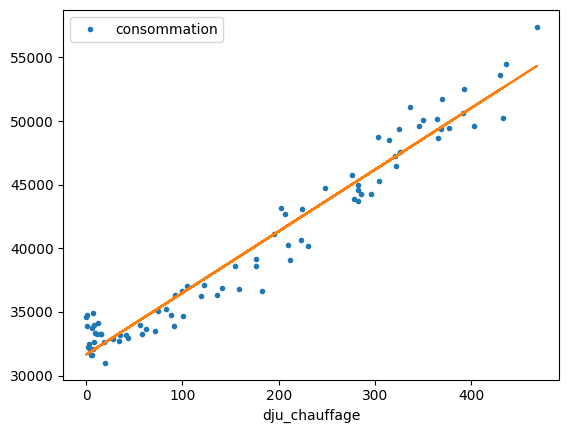

In [31]:
# Linear regression representation
df.plot(x='dju_chauffage', y='consommation', style='.')
plt.plot(df['dju_chauffage'], reg.predict(sm.add_constant(df['dju_chauffage'])))

plt.savefig("p9_graphic/regression_lineaire_conso_dju.png")
plt.show()

In [32]:
reg.params['dju_chauffage']

48.491916390569294

**Petite explication:**

Les DJU sont une unité qui permet de quantifier les besoins de chauffage sur une période donnée, en fonction des températures extérieures.

Prenons l'exemple d'une journée avec une température moyenne de 12°C.

La température de référence pour le chauffage est généralement fixée à 18°C.
La différence entre 18°C et 12°C est donc de 6°C.
Pour cette journée, on considère qu'il y a 6 DJU.
Maintenant, imaginons une journée où la température moyenne est de 8°C.

La différence avec la température de référence est de 10°C (18°C - 8°C).
Cette journée compte donc 10 DJU.
Plus les températures sont basses par rapport à la référence, plus le nombre de DJU est élevé. Cela traduit des besoins de chauffage plus importants.

À l'inverse, les jours où la température dépasse 18°C n'ont pas de DJU, car il n'y a pas de besoin de chauffage.

ALors quand le regression linéaire calcule la correlation entre la consommatin et le DJU, c'est ressortir le facteur (valeur "a") qui permet d'avoir la consommation d'energie par rapprot à un DGU en respectant la formule conso = a * DGU + b.

Ainsi, en ayant un DGU, on peut connaitre la consommation d'energie qui sera utilisé grâce au facteur a et dès lors, retrancher à la consommation totale observée (incluant celle du DGU) pour avoir la consommation sans effet de temperature.

In [33]:
# The linear regression is use to calculte the correlation facteur between the consumption and the dju. Now calcutate the correct consumption
df['conso_corr'] = df['consommation'] - df['dju_chauffage']*reg.params['dju_chauffage']

In [34]:
df

,consommation,dju_chauffage,conso_corr
mois,,,
2012-01-01,51086,336.0,34792.716093
2012-02-01,54476,435.9,33338.373645
2012-03-01,43156,201.9,33365.482081
2012-04-01,40176,230.3,29008.311655
2012-05-01,35257,83.3,31217.623365
...,...,...,...
2018-08-01,32451,3.3,32290.976676
2018-09-01,32683,34.3,31019.727268
2018-10-01,37102,122.4,31166.589434


In [35]:
df_cd=df.resample('MS').sum()
df_cd

,consommation,dju_chauffage,conso_corr
mois,,,
2012-01-01,51086,336.0,34792.716093
2012-02-01,54476,435.9,33338.373645
2012-03-01,43156,201.9,33365.482081
2012-04-01,40176,230.3,29008.311655
2012-05-01,35257,83.3,31217.623365
...,...,...,...
2018-08-01,32451,3.3,32290.976676
2018-09-01,32683,34.3,31019.727268
2018-10-01,37102,122.4,31166.589434


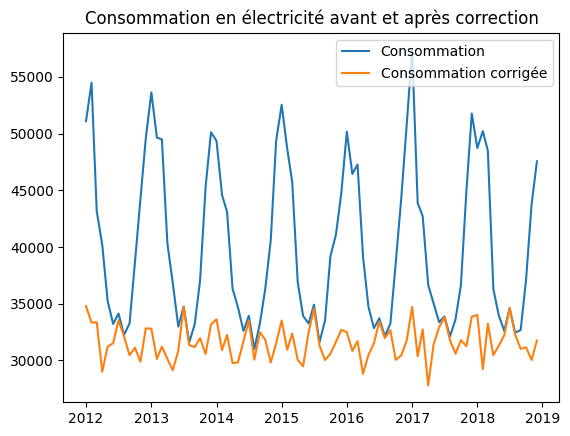

In [36]:
#Display energie consumption before and after correction
plt.plot(df['consommation'], label='Consommation')
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.savefig("p9_graphic/conso_corr.png")
plt.legend()
plt.show()

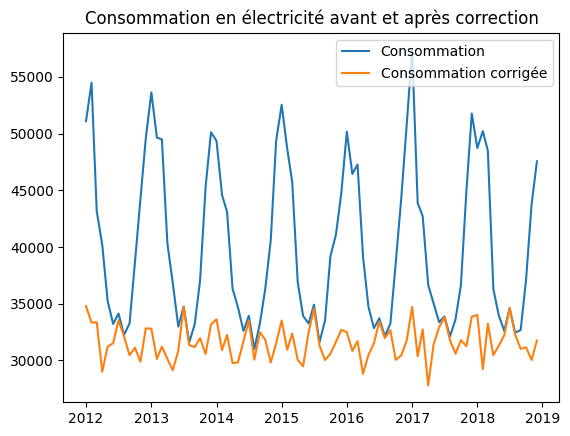

In [37]:
#Display energie consumption before and after correction
plt.plot(df_cd['consommation'], label='Consommation')
plt.plot(df_cd['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')


plt.legend()
plt.show()

### Residual normality test :
Inference in linear regression is based on the assumption of normality of errors. An important first check consists in verifying the compatibility of the residuals (the error observed on the sample).

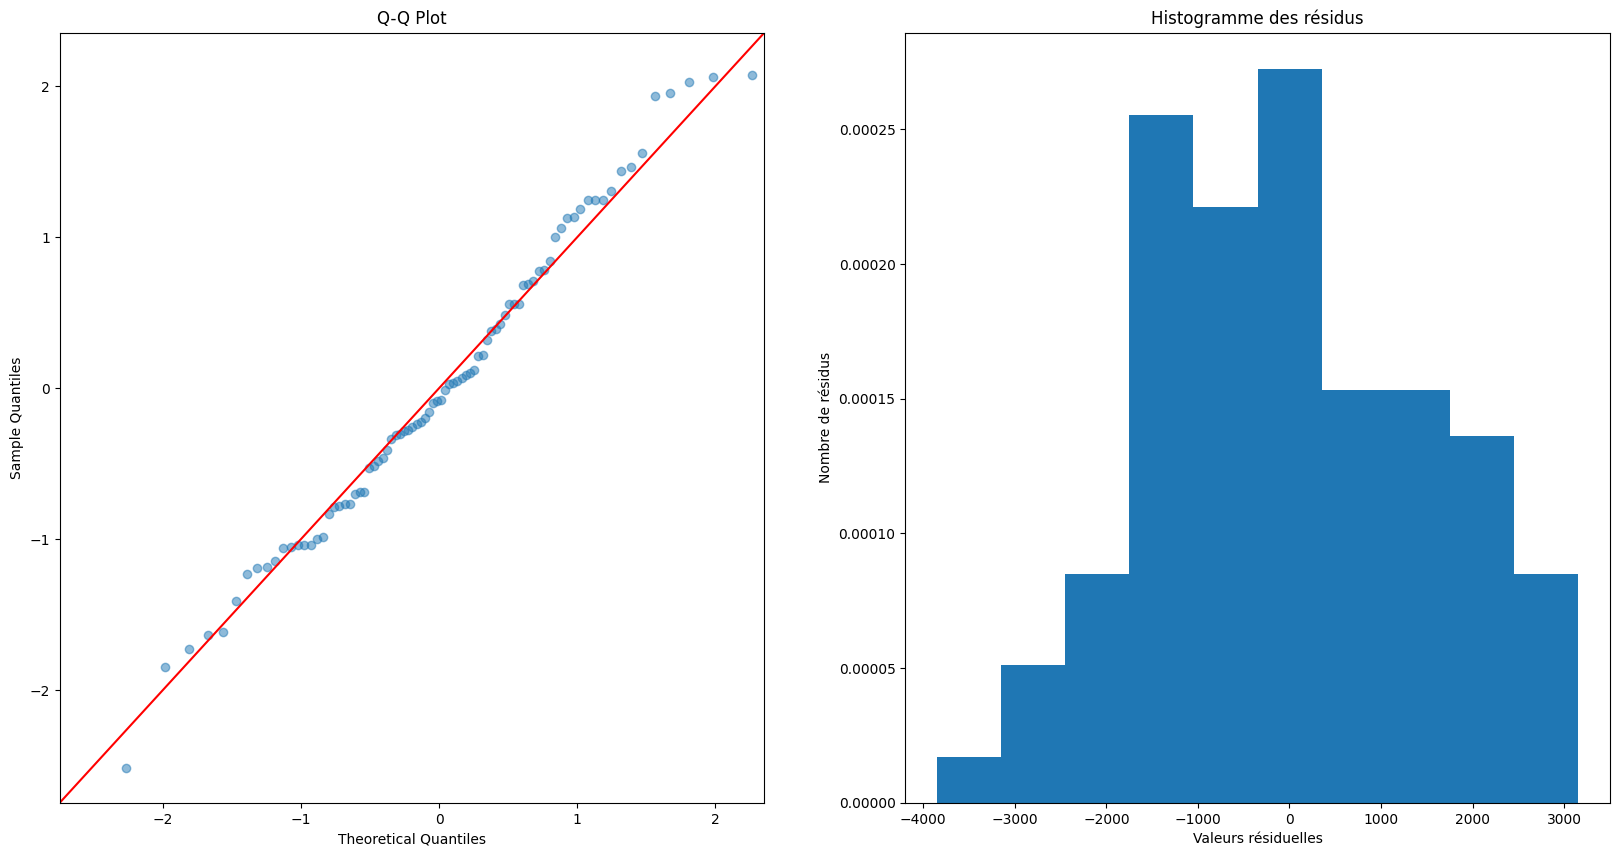

In [38]:
# Residue distributon
fig, ax = plt.subplots(1, 2, figsize=(20,10))

plt.hist(reg.resid, density=True)

model_norm_residuals = reg.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')
                
plt.savefig('p9_graphic/qqplot_histo_residus_reg.jpg')
plt.show()

On peut observer que les residus sont approximativement alignés sur la droite et le diagramme suit approximativement une forme de cloche, ce qui s'accorde avec une distribution d'une loi normale. Un test de Shapiro-Wilk est nécessaire pour valider ou rejeter cette intuition.

Le test de Shapiro-Wilk est un test statistique qui permet de vérifier si un ensemble de données suit une loi normale. Dans le cas d'un modèle de régression linéaire, on l'utilise spécifiquement pour tester la normalité des résidus.

**Hypothèses du test :**
H0 (hypothèse nulle) : les résidus suivent une loi normale
H1 (hypothèse alternative) : les résidus ne suivent pas une loi normale

**Calcul du test de Shapiro-Wilk :**
Le test de Shapiro-Wilk calcule une statistique W qui compare la distribution des résidus à une distribution normale théorique.
Plus la valeur de W est proche de 1, plus les résidus sont susceptibles de suivre une loi normale.

**Interprétation du résultat :**
Si la valeur-p (p-value) associée au test de Shapiro-Wilk est supérieure au seuil de significativité choisi (typiquement 5%), alors on ne peut pas rejeter l'hypothèse nulle.
Cela signifie que les résidus suivent bien une loi normale et que l'hypothèse de normalité est vérifiée.
Si la valeur-p est inférieure au seuil de significativité, alors on rejette l'hypothèse nulle : les résidus ne suivent pas une loi normale.

In [39]:
#Shapiro-Wilk test
shapiro(reg.resid)

ShapiroResult(statistic=0.9864239384940192, pvalue=0.5266761611892904)

the p-value is 0.526 more than 5%, so the H0 isn't rejected. The normal law is respected

## Seasonal adjustment of consumption using moving averages

The seasonal_decompose method from statsmodels visualizes the trend, seasonality and residual of the signal.

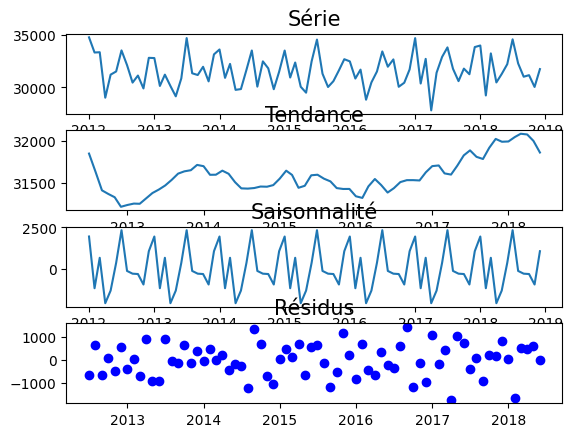

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df['conso_corr'],  model='additive')
fig, ax = plt.subplots(4,1)


ax[0].plot(decomposition.observed)
ax[0].set_title('Série', fontsize=15)



ax[1].plot(decomposition.trend)
ax[1].set_title('Tendance', fontsize=15)


ax[2].plot(decomposition.seasonal)
ax[2].set_title('Saisonnalité', fontsize=15)

ax[3].plot(decomposition.resid,'bo')
ax[3].set_title('Résidus', fontsize=15)

plt.savefig('p9_graphic/decomposition.jpg')
plt.show()

In [41]:
#Difference with seasonality to obtain a time series with no seasonal impact.
df['conso_cvs'] = df['conso_corr'] - decomposition.seasonal

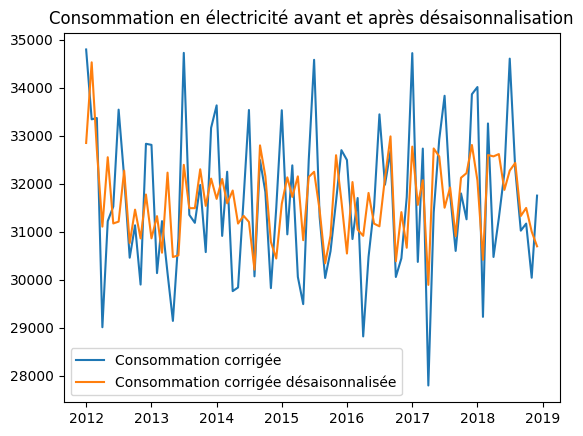

In [42]:
#consumptoin after and before saisonality
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_cvs'], label='Consommation corrigée désaisonnalisée')
plt.title('Consommation en électricité avant et après désaisonnalisation')

plt.savefig("p9_graphic/conso_cvs.png")
plt.legend()
plt.show()

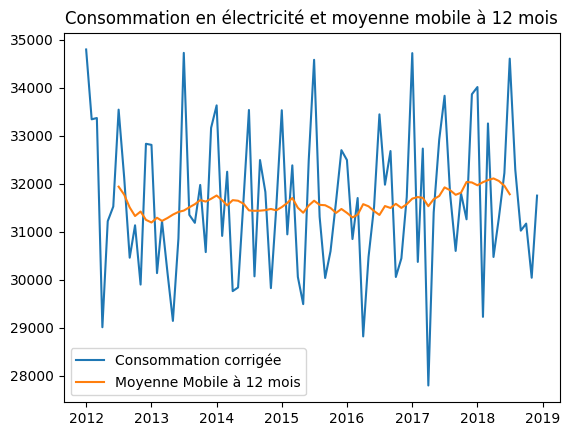

In [43]:
#View electricity consumption with 12-month rolling average
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_corr'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.savefig("p9_graphic/conso_moyenne_mobile.png")
plt.legend()
plt.show()

The 12-month moving average shown above is representative of a trendless signal, constant over the timeframe.

# Consumption forecast (corrected for temperature effect) over one year

The preconditioning phase will be carried out using the Holt-Winters method (exponential smoothing) followed by the SARIMA method.

## Prévision à l'aide du lissage exponentiel par la méthode de Holt-Winters
La méthode ExponentialSmoothing de statsmodels est utilisée pour modéliser le lissage exponentiel d'Holt-Winters.

In [44]:
from statsmodels.tsa.api import ExponentialSmoothing

y = np.asanyarray(df["conso_corr"])
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

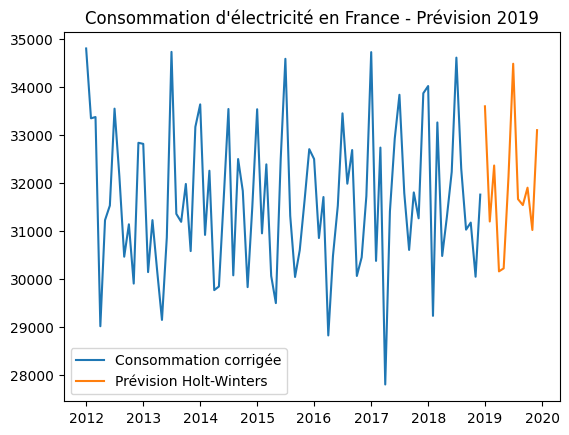

In [45]:
#Visualisation of the prevision at 12 months
plt.plot(df["conso_corr"], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision 2019")

plt.savefig("p9_graphic/prevision2019_holt-winters.png")
plt.legend()
plt.show()

The Holt-Winters method is the most reasonable of the exponential smoothing methods. The one-year consumption forecast, corrected for the temperature effect, takes seasonality into account. Below is a visualization by restriction over the 2018/2019 period.

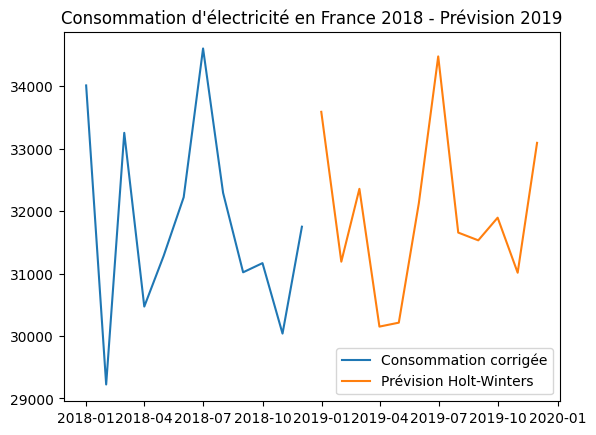

In [46]:
#Visualisation on 2018/2019
plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France 2018 - Prévision 2019")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182019_holt-winters.png")
plt.show()

### A posteriori analysis
We truncate the 2018 series, which we then try to forecast on the basis of the 2012-2017 history. This analysis gives an idea of the predictive quality of the chosen model.

In [47]:
#Troncature of data for 2017 and 2018
df_tronc = df[:'2017']
x_prevision = df['2018':]

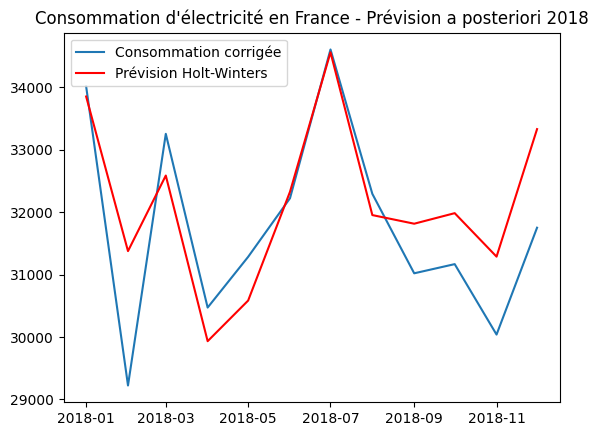

In [48]:
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision a posteriori 2018")

plt.savefig("p9_graphic/prevision_visu20182019_holt-winters_aposteriori.png")
plt.legend()
plt.show()

Using numbers, we can calculate the MAPE (Mean Absolute Percentage). The Mean Absolute Percentage Error, in other words, the average of absolute deviations from observed values.

In [49]:
#Calcul of MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
mape

2.47

ValueError: x and y must have same first dimension, but have shapes (12,) and (24,)

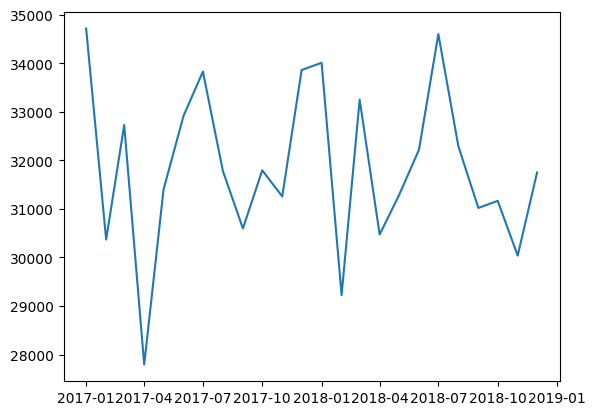

In [50]:
#Visualisation par restriction sur les années de prévision 2017 et 2018
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(24)

plt.plot(df["conso_corr"].iloc[-24:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='r', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France a posteriori 2017/2018")

plt.savefig("p9_graphic/prevision_visu20172018_holt-winters_aposteriori.png")
plt.legend()
plt.show()

In [51]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
print("MAPE :" + str(mape))

MAPE :2.47


This indicator will enable us to make a comparison with future forecasts, so that we can decide on the best-performing model. For the time being, a posteriori analysis doubled over 24 months suggests that the model is fairly resistant to seasonal impacts over the long term. That said, peak and trough surpluses are not entirely predictable by the model, so will SARIMA forecasts be more representative of variations in electrical load?

### Forecasting using a seasonal ARIMA model format: SARIMA(p,d,q)(P,D,Q)(t)

Several steps are required:
1. Identify/confirm seasonality s (autocorrelograms)
2. Station the time series (differentiation)
3. Determine plausible optimal orders
4. Estimate parameters and rank them by AIC (or BIC)
5. Validate or not the model by diagnosing residuals (test, graphical representation, autocorrelogram).
6. Confirm choice(s) by simulating the forecast.


### Stationarity and differentiation of the series :

We're dealing with a time series marked by strong seasonality, very typical of climatic temperatures. It is not possible to model it directly as a stationary process, so stationarity will be applied. The method chosen will be differentiation.

In [52]:
#Function displaying the Dickey-Fuller Test with ACF and PACF autocorrelograms
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

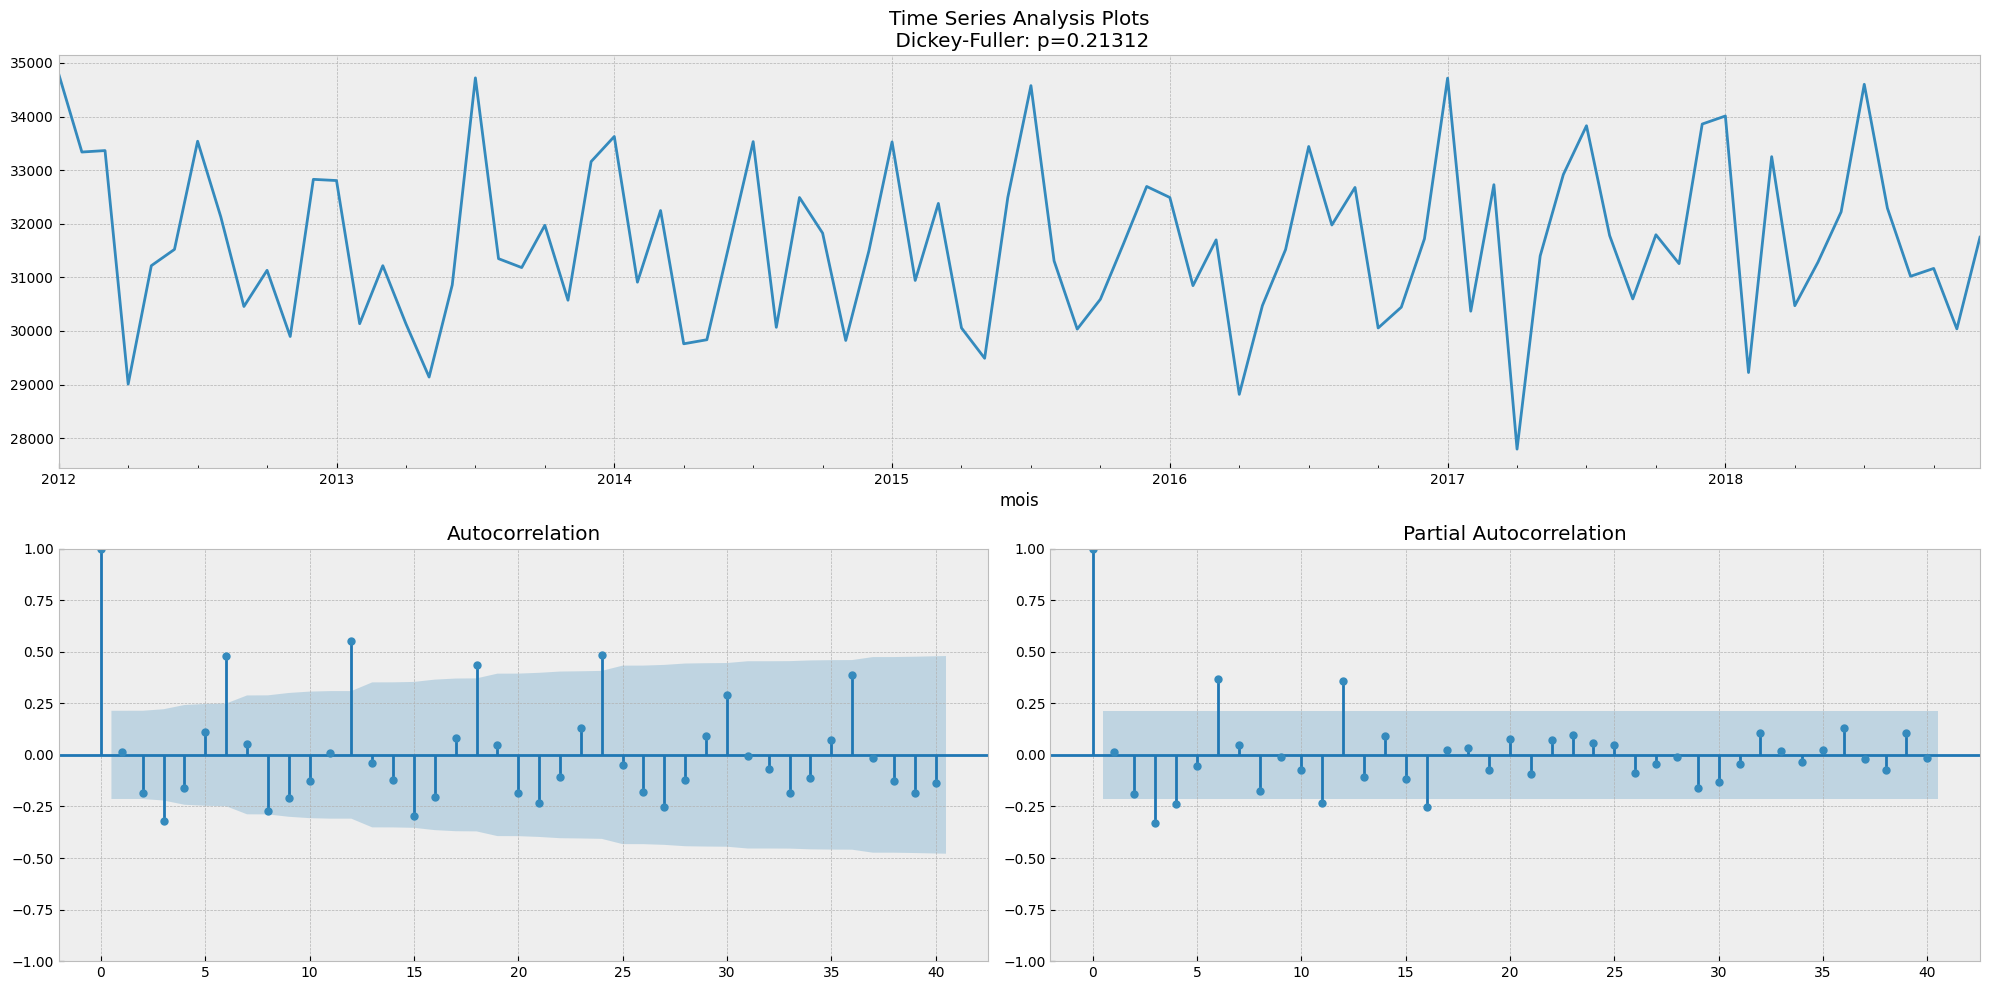

In [53]:
#Dickey-Fuller test with ACF and PACF autocorrelograms
tsplot(df['conso_corr'], lags=40)

The ACF output shows a slow decay towards 0, indicating a non-stationarity problem. This is also confirmed by the Dickey-Fuller test, with the null hypothesis that the series is non-stationary, which cannot be rejected. An initial differentiation is therefore made.

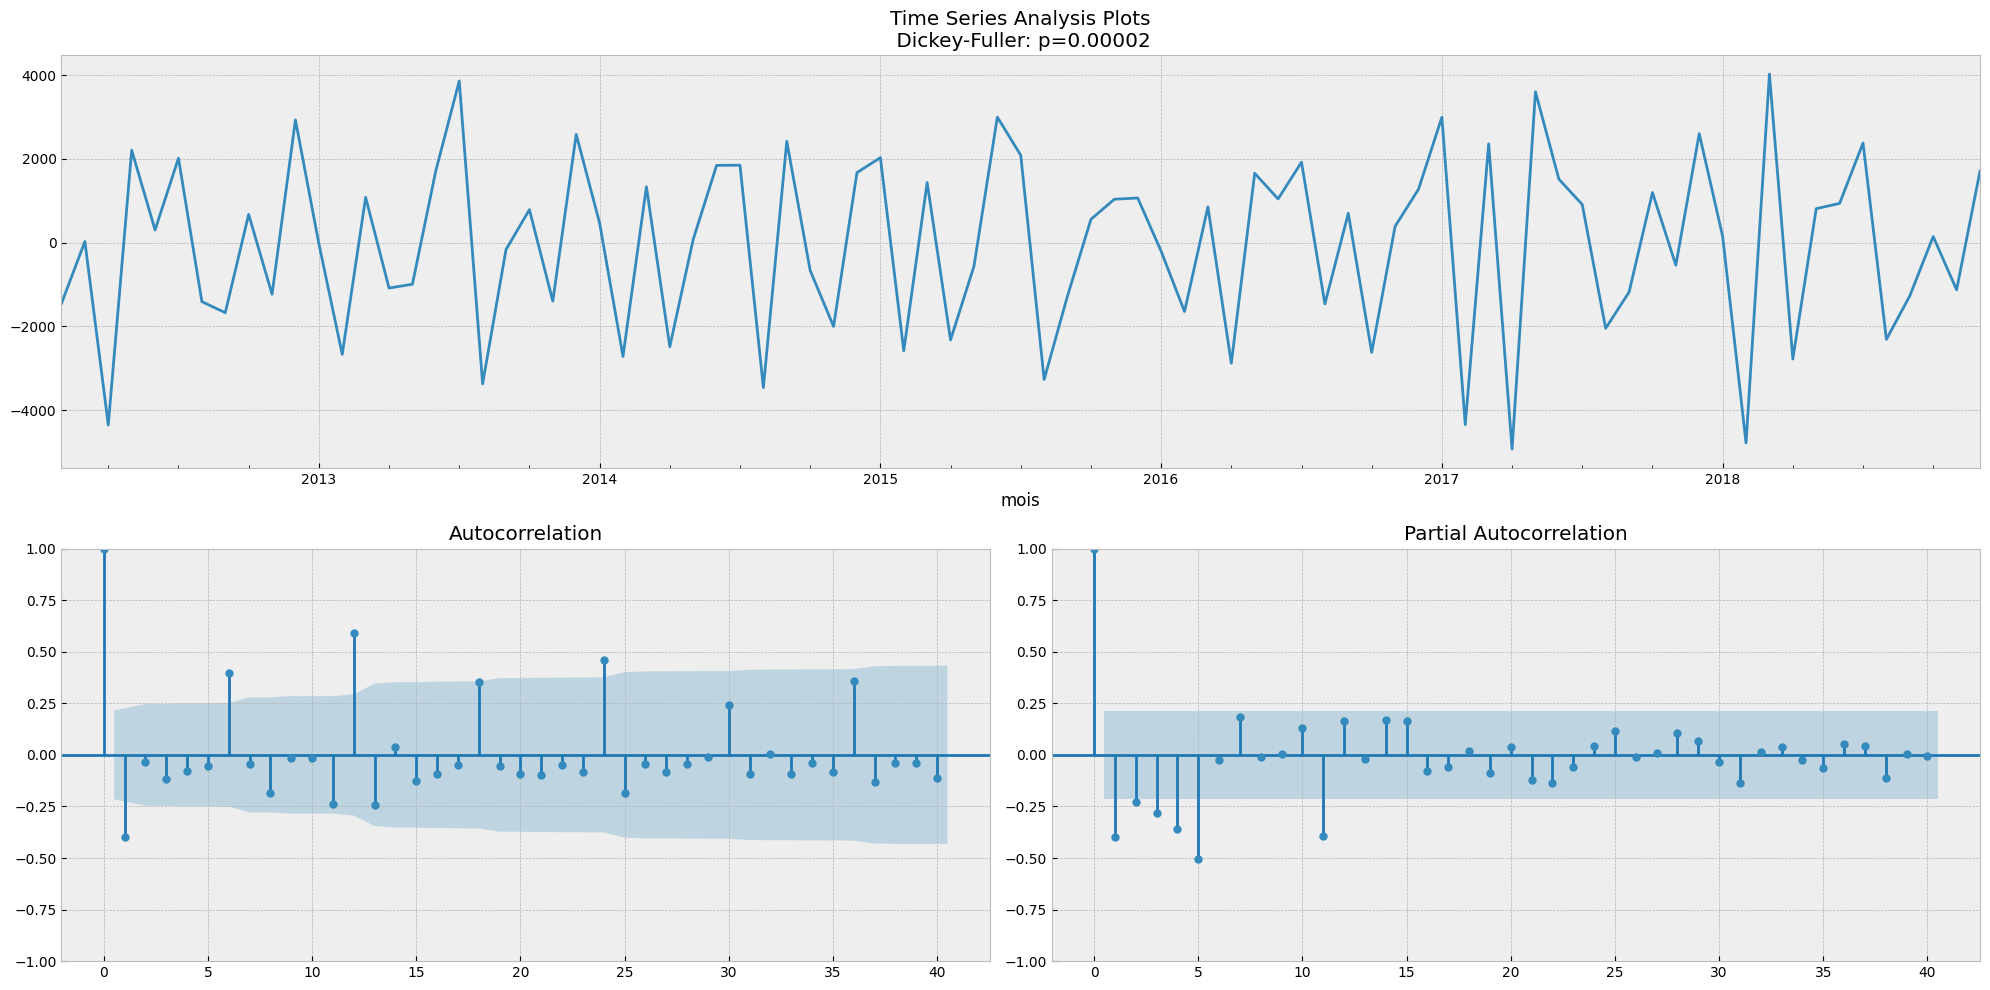

In [54]:
#1st order differentiation by .shift() method
df_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
tsplot(df_diff1[1:], lags=40)

The ACF output of the differentiated series still shows a slow decay towards 0 for multiples of 12. This time, we perform differentiation of order 12.

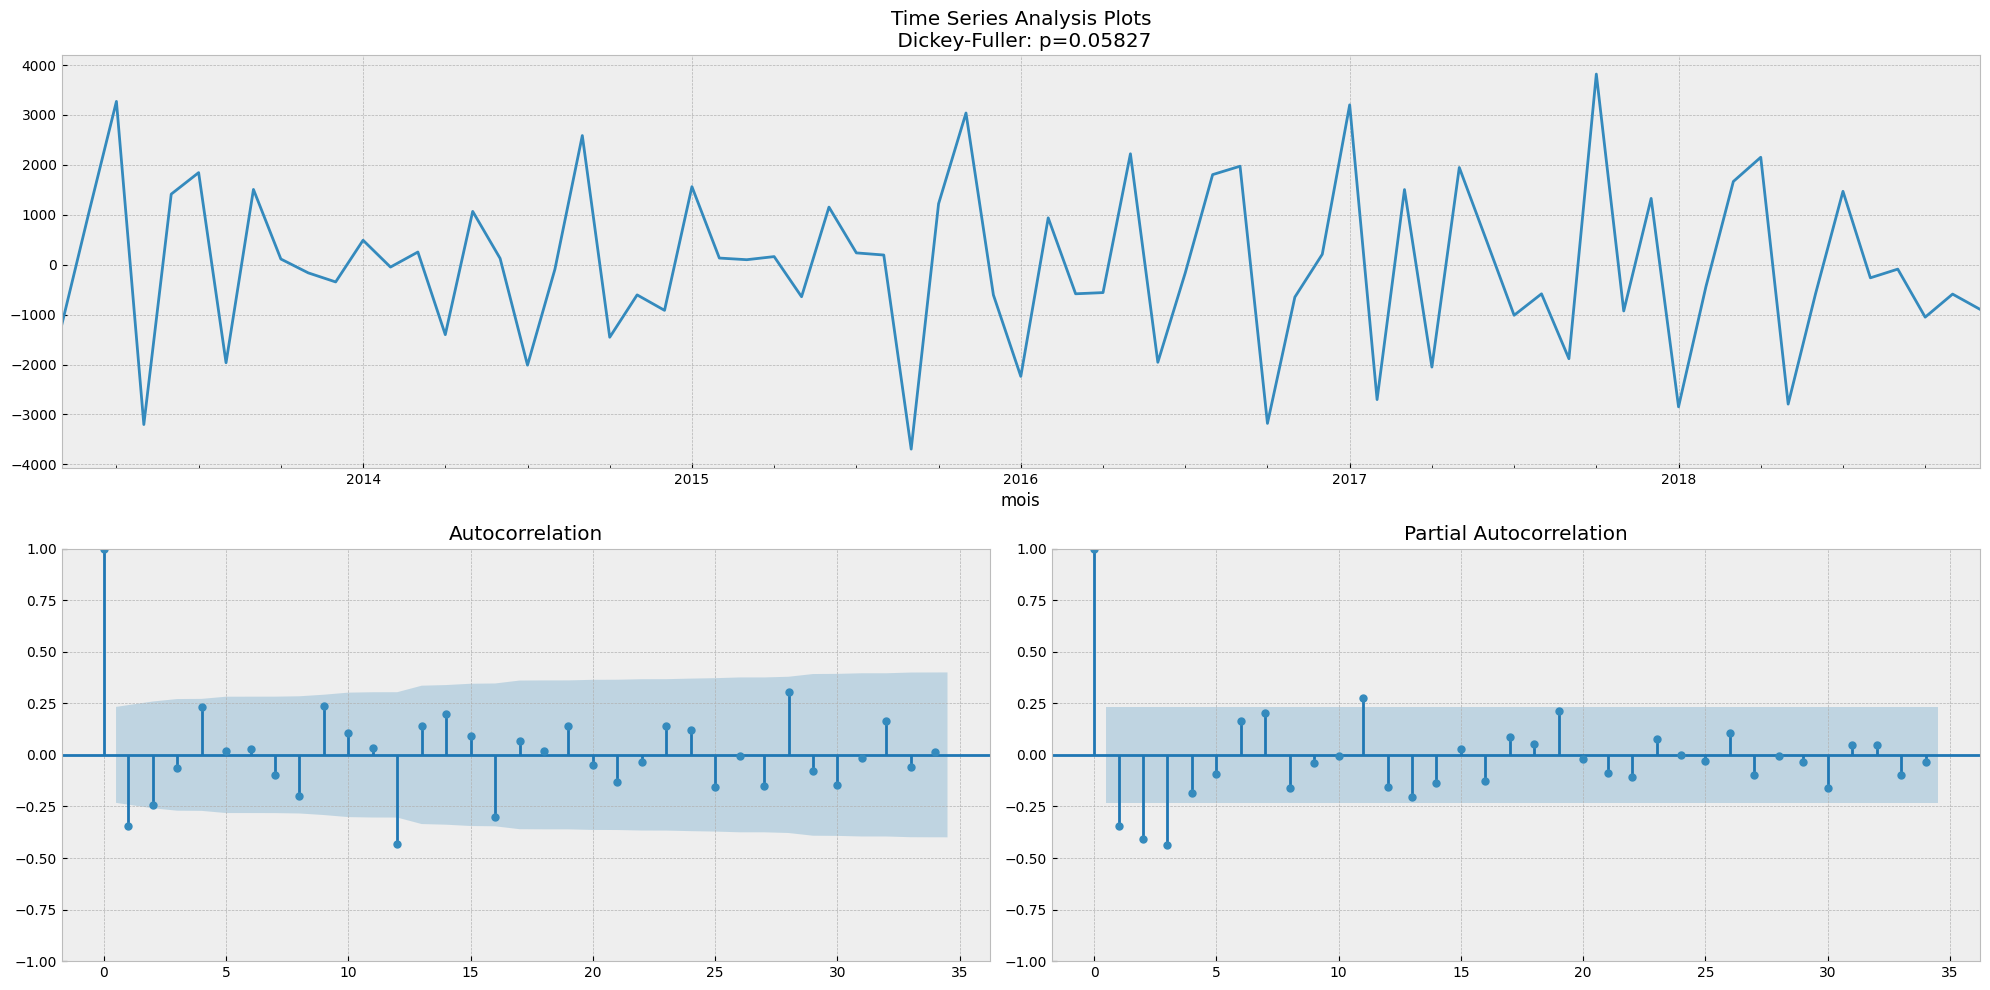

In [55]:
#Second order 12 differentiation 
df_diff1_12 = df_diff1 - df_diff1.shift(12)
tsplot(df_diff1_12[13:], lags=34)

This time the results are satisfactory, and we can rely on the estimated simple and partial autocorrelograms.

### SARIMA optimal configuration generation:

Combinations will be identified using the AR and MA polynomial optimization approach. We aim to minimize the Akaike AIC information criterion to determine optimal orders. The whiteness and normality of the residue is also a criterion to be taken into account.

In [57]:
#Determining the best forecasting model 

from time import time
DUREE_PREDITE = 12 #prédiction over 12 mois
troncature = DUREE_PREDITE
y = df['conso_corr']
y_prevision = y[-troncature:]

#Calculation of all combinations of p, d and q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))

#Calculation of all combinations of P, D and Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]

print("pdq_list", pdq_list)
print("PDQ_list", PDQ_list)

#Total number of configurations for a SARIMA model
n = len(pdq_list) * len(PDQ_list)

#Dataframe for storing values
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[], 'ljungbox':[], 'pvalues':[]})

counter = 1
s_time = time()

#Iteration on all combinations
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            print("try")
            #Instantiation and training of the SARIMA model
            mod = SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
                    
            #Integration of indicators into previous dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            'ljungbox': acorr_ljungbox(result.resid, lags=12)[1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
            print(results_SARIMA)
        except:
            continue
            
        clear_output(' ')
        print(f"{counter}/{n} - {time() - s_time:.0f}s")
        counter += 1

print(results_SARIMA)

pdq_list [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
PDQ_list [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12)]
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try
try


From the 324 models, a finer selection can be made by sorting only those that meet the following criteria:

In [58]:
#Selection of the most optimal SARIMA models based on parameter significance tests 
#and residual whiteness are validated at 5% level
results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA_filter[results_SARIMA_filter['pvalues'] < 0.05]

In [59]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)

In [60]:
#Preview of the 30 best-performing models out of the initial 324
def highlight_greaterthan(x):
    if x.rank_aic == 25:
        return ['background-color: #2399f9']*7
    else:
        return ['background-color: None']*7

results_SARIMA_filter.sort_values('rank_aic', ascending=True)[:30].style.apply(highlight_greaterthan, axis=1)

,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic


According to AIC and BIC criterion minimization, the (1, 1, 1)x(2, 1, 1, 12) model emerged as the most optimal. This choice was made after several tests on several models, and emerged as the best-performing model, also taking into account the significance of the parameters, and the whiteness of the residual estimated using the Ljung-Box test. The tests for parameter significance and residual whiteness are validated at the 5% level.

In [61]:
#SARIMA model implementation and training via statsmodels
model = SARIMAX(np.asarray(y), order=(1,1,1), seasonal_order=(2,1,1,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -615.377
Date:                            Mon, 27 May 2024   AIC                           1242.754
Time:                                    16:52:30   BIC                           1256.331
Sample:                                         0   HQIC                          1248.153
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5840      0.155      3.760      0.000       0.280       0.888
ma.L1         -0.7093      0.149   

### Residual normality :

For forecasting purposes, we need to check the normality of residuals to test the suitability of our models. Normality can be detected graphically, but statistical tests provide a significant objective point of view.

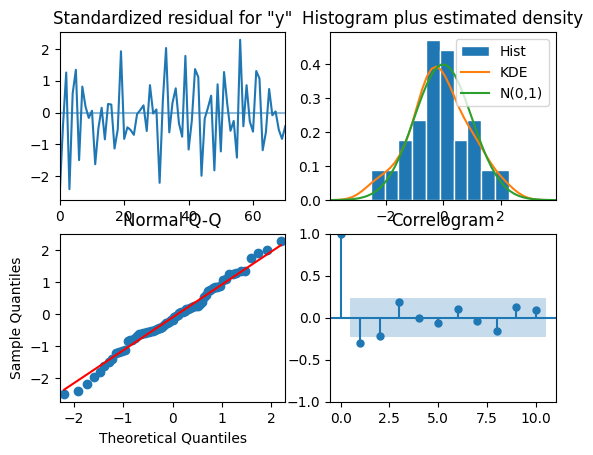

In [62]:
#The .plot_diagnostics() function is used to quickly diagnose the SARIMA model identified. 
fig = results.plot_diagnostics()

The “Standardized residual” and “Correlogram” representations confirm that the residuals are not correlated. Residuals are normally distributed KDE vs. normal distribution - N (0,1). The ordered distribution of the residuals represented by the Q-Q plot is globally satisfactory, although there are small divergences towards the tails of the distribution. It is interesting to couple the visual approach with statistical tests.

In [63]:
#Test of Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)

ShapiroResult(statistic=0.4359845199577377, pvalue=2.3092577852217644e-16)

In [64]:
#Test OF Jarque-Bera
results.test_normality("jarquebera")[0][1]

0.9845374186047741

According to the literature, this test does not take into account the first residuals, which recalls the first finding of the Q-Q plot: the first residuals diverge slightly from a Gaussian pattern, so the test does not take them into account and therefore becomes conclusive without being able to reject the null hypothesis of residual normality in this precise context.

Here, the normality hypothesis is challenged by Shapiro (p-value < 0.05).

Nevertheless, observation of the residuals, the fact that they are not very different from a symmetrical distribution, and the fact that the sample is of sufficient size mean that the results obtained by the model are not absurd, even if the residual is not considered to be Gaussian.

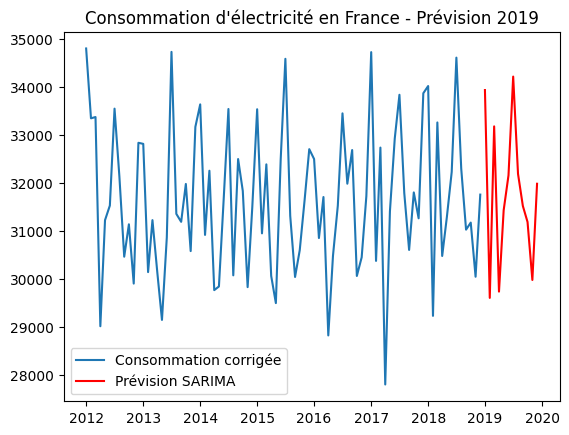

In [65]:
#Visualization of the 12-month forecast using the SARIMA method
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')

plt.title("Consommation d'électricité en France - Prévision 2019")
plt.legend()

plt.savefig('p9_graphic/sarima_prevision2019.jpg')
plt.show() 

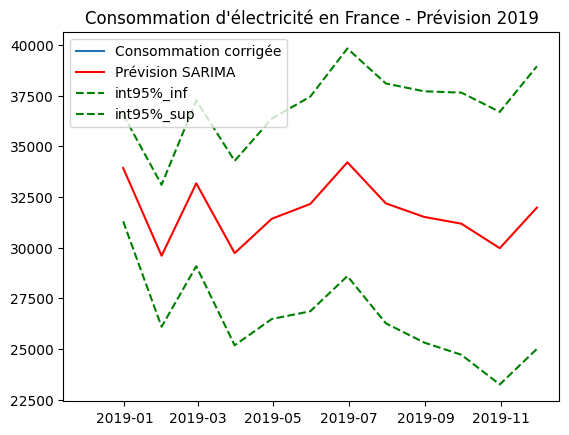

In [66]:
#Visualization of confidence intervals on the 12-month forecast
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.plot(df['conso_corr'].iloc[-1:], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_u, color='g', linestyle='--', label='int95%_sup')

plt.title("Consommation d'électricité en France - Prévision 2019")
plt.legend()

plt.savefig('p9_graphic/sarima_prevision2019_int95.jpg')
plt.show() 

An overall satisfactory confidence interval. Note that there seems to be a greater level of uncertainty over a longer forecast period.

### A posteriori analysis

We truncate the 2018 series, which we then try to forecast from the 2012-2017 history.

In [67]:
#Troncature of data for 2017 and 2018
df_tronc = df[:'2017'] 
x_prevision = df['2018':]  

In [78]:
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,1,1), seasonal_order=(2,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt).mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -408.788
Date:                            Mon, 27 May 2024   AIC                            829.575
Time:                                    17:01:49   BIC                            840.676
Sample:                                         0   HQIC                           833.753
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6784      0.244      2.780      0.005       0.200       1.157
ma.L1         -0.7538      0.229   

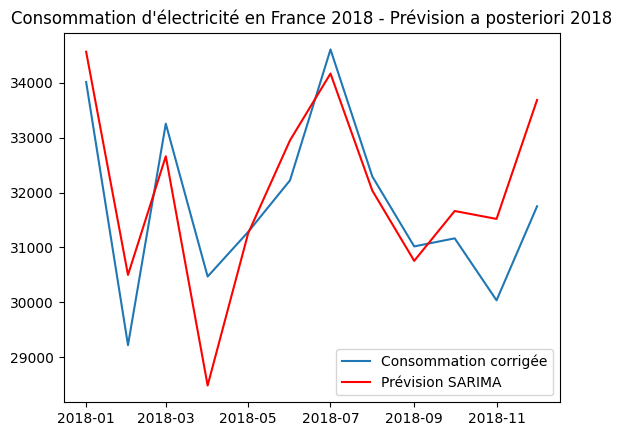

In [70]:
#View by restriction for 2018
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("Consommation d'électricité en France 2018 - Prévision a posteriori 2018")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182018_sarima_aposteriori.png")
plt.show()

In [71]:
mape = round((np.abs(1-pred_tronc/x_prevision["conso_corr"])).mean()*100, 2)
mape

2.68

SARIMA's 12-month forecasting performance does not stop strictly at MAPE, but seems to take better account of seasonal impacts (peaks and troughs).

In [72]:
#Data truncation for 24-month hindcasts
df_tronc = df[:'2016']
x_prevision = df['2017':]

In [77]:
model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,1,1), seasonal_order=(2,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt).mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -408.788
Date:                            Mon, 27 May 2024   AIC                            829.575
Time:                                    17:00:11   BIC                            840.676
Sample:                                         0   HQIC                           833.753
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6784      0.244      2.780      0.005       0.200       1.157
ma.L1         -0.7538      0.229   

Note that it is not easy to test a 24-month hindcast without having to re-optimize the model. Here, a seasonal AR parameter is no longer significant, so it would be necessary to retest it in order to re-evaluate the prediction. Here, there's no need to go any further in this process of re-optimizing the model, as the one chosen satisfies our 12-month prediction objectives.

### Conclusion

In this study, we used monthly data on electricity consumption in France, together with the temperature effect of heating, to test models for predicting this consumption over 12 months. The exploration of these data revealed characteristics such as the non-stationarity of the electricity consumption series and its very high inertia (strong and long autocorrelation). Two differentiation processes were required to make the series stationary.

Forecasts using the Holt-Winters exponential smoothing method and SARIMA are globally satisfactory, with the mean absolute percentage error below 3%. In addition, the SARIMA model will be chosen first and foremost to predict more punctual (short-term) electricity consumption, as it will perform better and be more robust in forecasts that have to take account of strong seasonal impacts.